# Project 4 - West Nile Virus Prediction (Team CJE)

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Preprocessing stuff
from sklearn.preprocessing import (
    LabelEncoder, 
    LabelBinarizer, 
    StandardScaler
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline


# Import SMOTENC to deal with categorical columns
# from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Import models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier, 
    AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

# For creating mosquito clusters
from sklearn.cluster import (
    KMeans, 
    DBSCAN, 
    AgglomerativeClustering
)

# Performance measurement stuff
from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix, 
    f1_score,
    roc_auc_score, 
    plot_roc_curve, 
    roc_curve
)
# Measure runtime
import time

import warnings
warnings.filterwarnings('ignore')

# To calculate geo-distance
# !pip install haversine
# import haversine as hs

## Load data

In [2]:
# !git clone https://github.com/kl503/DSI-SG-24-projects.git

In [3]:
# Do not load unless you want groupmates to enter authorization code
# from google.colab import drive
# drive.mount('drive')

In [4]:
# !ls

In [5]:
# # Activate only when running CoLab
# train = pd.read_csv("DSI-SG-24-projects/project_4/data/train.csv")
# test = pd.read_csv("DSI-SG-24-projects/project_4/data/test.csv")
# spray = pd.read_csv("DSI-SG-24-projects/project_4/data/spray.csv")
# weather = pd.read_csv("DSI-SG-24-projects/project_4/data/weather.csv")
# kaggle = pd.read_csv("DSI-SG-24-projects/project_4/data/sampleSubmission.csv")

In [6]:
# # Activate only when running on local desktop
# train = pd.read_csv("../data/train.csv")
# test = pd.read_csv("../data/test.csv")
# spray = pd.read_csv("../data/spray.csv")
# weather = pd.read_csv("../data/weather.csv")
# kaggle = pd.read_csv("../data/sampleSubmission.csv")

In [7]:
## Load files

# # Jasper's
# train = pd.read_csv("../data/train_filtered.csv")
# test = pd.read_csv("../data/test_filtered.csv")
# kaggle = pd.read_csv("../data/sampleSubmission.csv")

# Ethan's
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')
kaggle = pd.read_csv("../data/sampleSubmission.csv")

## Methodology

These are our modeling assumptions:
- We remove duplicated rows with similar \['Date' & 'Species' & 'Trap'\], as they are created because of multiple mosquito test samples for that particular trap on that day. Removal of these duplicated rows is necessary, otherwise our models will give overly-heavy weights to Traps with a lot of test sample, e.g. Trap 'T115' with 64 rows (test samples) on '2007-07-25'. To be conservative, if at least test sample is positive for a particular \['Date' & 'Species' & 'Trap'\], we will assume all other test samples for that \['Date' & 'Species' & 'Trap'\] are positive. For example, if T115 has 3 out of 10 test samples that are positive for PIPENS/RESTUANS on 2007-07-25, we will assume all are positive so that we ensure that we get a positive value for WnvPresent after 9 out of 10 duplicated rows are dropped.
- Variables that we use are:
    - Species
    - Trap
    - Longitude
    - Latitude
    - Weather-related features: Tmax, Tmin, Tavg, DewPoint, WetBulb, PreciptTotal
    - Month 
    - Week of the year (not to be confused with week of the month)
- We assume that mosquitoes have a life cycle of 7 days, as seen in the graphics below. Any effect on the breeding of mosquitoes due to changes in weather might be seen only after a few days. Therefore, we also lagged the weather variables by up to 7 days (i.e. lag = 0, 1, 2, ..., 6, 7) in an attempt to capture these delayed effects.
- Species, Trap, Month, Week are one-hot encoded to dummies.

<div>
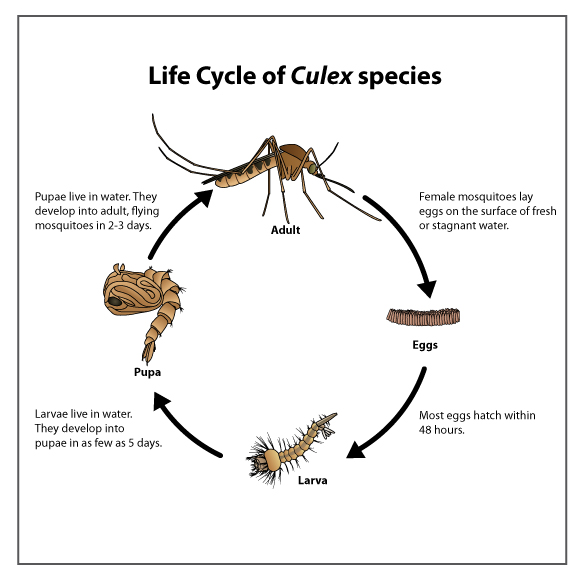
</div>

<div>
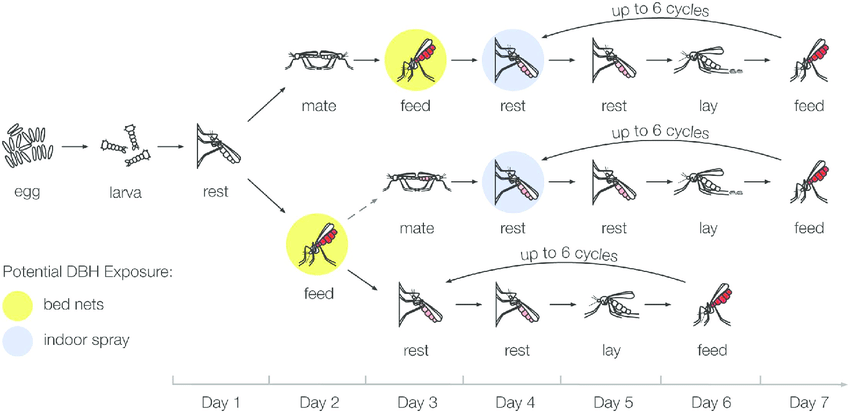
</div>


We break our analysis up into 7 steps:
- Step 1: We test our features on 6 basic models (Logistic, KNeighbors, Random Forest, Extra Trees, Support Vector, XGBoost).
- Step 2: We take the top two performing models in Section 1 and do an intensive grid search on them.
- Step 3: We take the finely-tuned models from Section 2, and drop the 'month' hot-encoded categories. Month of the year is correlated to week of the year, but it could provide useful predictive information. Dropping it is to check if the extra predictive ability is good enough to counteract the negative effects of collinearity. 
- Step 4: Lagged weather variables are time series in nature and suffers from auto-correlation, but it could provide predictive ability due to the life cycle of mosquitoes. Here we reduce the lagged weather variables from 7 days to 3 days, in the hope that we reduce the effects of collinearity without sacrificing too much predictive information.
- Step 5: We test out the scenario where the lag for weather variables are further reduced to just 1 day, i.e. we only have lag = 0 and lag = 1 in the model.
- Step 6: Here, we replace Longitude and Latitude with "mozzie clusters" formed by the KMeans algorithm. The reasoning is that while we see some evidence of more WNV-positive cases in the western parts of Chicago than eastern parts, using Long/Lat is too blunt an instrument. Ideally, it should be based on the built-up features and demographics of Chicago, e.g. landed housing areas are more prone to WNV, high population areas are more prone. Since we do not have such information, the next best step is to use a clustering algorithm to derive mosquito prone clusters. The KMeans algorithm is fitted with \['Longitude', 'Latitude', 'NumMosquitos' & 'WnvPresent'\]. 
- Step 7: Same as Section 6, but 'mozzie clusters' are estimated using the DBSCAN algorithm.

Assessment metric:
- We shall use ROC_AUC as the scoring method
- We shall first look at test score, followed by the average 5-fold CV score
- Finally we submit the Kaggle predictions to be used as 3rd set of scoring metric

## Train/Test Split, Encoding and Standard Scaling

As seen above, two columns `Species` and `Trap` have dtype == 'objects' and hence are categorical features. Let's check if we have more categories in Test set that are not seen in the Train set, as that could lead to under-fitting issues.

In [8]:
print(f"No. of unique species in: \
\n train set: {train['Species'].nunique()} \
\n test set: {test['Species'].nunique()}")
print()
print(f"No. of unique traps in: \
\n train set: {train['Trap'].nunique()} \
\n test set: {test['Trap'].nunique()}")

No. of unique species in: 
 train set: 7 
 test set: 8

No. of unique traps in: 
 train set: 136 
 test set: 149


Indeed, there are more mosquito species in Train than Test. It can be a big problem if the 8th species happen to be a type that carries positive WNV (like PIPIENS, PIPENS/RESTUANS, RESTUANS), because any model will give it a strong negative likelihood because it has not seen that species before.

Same problem for Traps, as there are 13 more traps that are not seen and won't be fitted in the Train set. However, that is an easier problem to solve, as i can to create neighborhood clusters based on WnvPresent and GPS coordindates. And based on NumMosquitoes, WnvPresent and GPS coords. Then use KNN to train and map these clusters to the Test set's GPS coordinates.

In [9]:
# Create X and Y, remove Latitude as it has no meaning looking at the EDA infection map
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6356, 54), (2119, 54), (6356,), (2119,))

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6356 entries, 4903 to 6053
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Species           6356 non-null   object 
 1   Trap              6356 non-null   object 
 2   Latitude          6356 non-null   float64
 3   Longitude         6356 non-null   float64
 4   Date_month        6356 non-null   int64  
 5   Tmax              6356 non-null   float64
 6   Tmin              6356 non-null   float64
 7   Tavg              6356 non-null   float64
 8   DewPoint          6356 non-null   float64
 9   WetBulb           6356 non-null   float64
 10  PrecipTotal       6356 non-null   float64
 11  Tmax_lag1         6356 non-null   float64
 12  Tmax_lag2         6356 non-null   float64
 13  Tmax_lag3         6356 non-null   float64
 14  Tmax_lag4         6356 non-null   float64
 15  Tmax_lag5         6356 non-null   float64
 16  Tmax_lag6         6356 non-null   float

In [12]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_month', 'Date_week']
continuous_cols = [col for col in X.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

# Create Z_ data set for Kaggle, refitted based on full train set
Z = mapper.fit_transform(X)
Z_kaggle = mapper.transform(X_kaggle)

In [13]:
# Check transformed columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

display(Z_train)
display(Z_test)

,Latitude,Longitude,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmax_lag4,Tmax_lag5,Tmax_lag6,Tmax_lag7,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tmin_lag4,Tmin_lag5,Tmin_lag6,Tmin_lag7,Tavg_lag1,Tavg_lag2,Tavg_lag3,Tavg_lag4,Tavg_lag5,Tavg_lag6,Tavg_lag7,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,DewPoint_lag4,DewPoint_lag5,DewPoint_lag6,DewPoint_lag7,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,WetBulb_lag4,WetBulb_lag5,WetBulb_lag6,WetBulb_lag7,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,PrecipTotal_lag4,PrecipTotal_lag5,PrecipTotal_lag6,PrecipTotal_lag7,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41
4903,-1.602313,1.133388,-1.594119,-0.414386,-1.122594,-0.484309,-0.795577,-0.462624,-1.208497,-0.785583,1.012977,-0.124583,0.271211,0.473113,0.150502,-0.080830,0.309871,0.670165,0.622996,0.172591,-0.140136,-0.059584,-0.671845,-0.266953,0.901987,0.249626,0.202697,0.208126,0.009648,0.031520,0.503113,1.447464,1.126191,0.839728,0.439326,0.261411,-0.267650,0.178948,1.299682,0.836856,0.755944,0.277848,0.159322,-0.336896,-0.363120,0.722332,2.940692,-0.321297,-0.425451,-0.390366,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6913,-0.946417,-0.430646,0.609664,0.963762,0.790436,1.405126,1.255580,1.526073,0.960578,0.242464,0.714293,0.335030,-0.875622,-1.481108,-0.826392,0.949019,0.742880,-0.188388,-0.601821,-0.311456,-0.291964,-0.335163,1.008115,0.495727,0.285134,-0.114278,-0.637115,-1.046741,-0.658140,0.903118,0.700910,0.207086,0.217048,0.188201,-0.850446,-0.949849,1.018090,0.656110,0.304841,0.121779,-0.267053,-1.013265,-0.867308,-0.418017,-0.399946,-0.426461,-0.475648,-0.144268,-0.425451,-0.390366,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,Latitude,Longitude,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmax_lag4,Tmax_lag5,Tmax_lag6,Tmax_lag7,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tmin_lag4,Tmin_lag5,Tmin_lag6,Tmin_lag7,Tavg_lag1,Tavg_lag2,Tavg_lag3,Tavg_lag4,Tavg_lag5,Tavg_lag6,Tavg_lag7,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,DewPoint_lag4,DewPoint_lag5,DewPoint_lag6,DewPoint_lag7,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,WetBulb_lag4,WetBulb_lag5,WetBulb_lag6,WetBulb_lag7,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,PrecipTotal_lag4,PrecipTotal_lag5,PrecipTotal_lag6,PrecipTotal_lag7,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41
5601,1.213004,-1.305828,0.252294,0.832510,0.526570,1.090220,0.962558,-0.462624,0.258819,0.726252,1.490871,1.385575,1.354331,1.418703,0.708727,0.811706,1.392393,1.600264,1.775764,1.071536,0.694921,1.387208,0.588125,1.050403,1.655918,1.705241,1.252461,1.167731,1.122629,0.903118,1.030572,1.839162,1.710640,1.360950,0.778739,1.281420,0.791195,1.133272,1.911892,1.790291,1.464172,1.084793,1.264925,-0.418017,-0.399946,1.112488,-0.475648,-0.321297,-0.425451,1.164700,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
796,-0.383976,0.620789,1.205281,0.766884,1.054303,0.397427,0.742791,-0.462624,1.151967,0.847198,0.535083,-0.058924,0.398637,0.473113,0.429614,0.743049,0.093367,0.312434,0.767092,1.002387,0.315350,1.111629,1.008115,0.565061,0.422213,0.322406,0.762571,0.429574,0.825834,0.156034,-0.354008,-0.315179,0.866436,1.165492,0.846622,0.325162,0.564300,0.099421,-0.001264,0.677950,0.992020,0.681321,0.475209,-0.418017,-0.399946,-0.426461,-0.475648,0.091770,0.863161,-0.390366,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Re-balance the Train set via SMOTE-NC

In [14]:
# Check for imbalance dataset
y_train.value_counts(normalize = True)

0    0.946035
1    0.053965
Name: WnvPresent, dtype: float64

As seen above, the WNV is only present in about 5% of the dataset. This means that a 'lazy' model can always predict WnvPresent = 0 and still achieve a high accuracy score of 95%. To avoid training a model this way, we will use the SMOTE function to oversample the minority variable to achieve a 50-50 breakdown between Positive and Negative WNV cases.

Within the SMOTE family, there are `SMOTE, SMOTENC, SMOTEN` functions, where the first is the default, the second deals with dataset continaing numerical and categorical features, and the third deals with dataset only made of categorical features.

We tested both versions `SMOTE, SMOTENC` and found that the latter provides better prediction results.


In [15]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train.columns[:34]
cat_col_names = Z_train.columns[34:]
num_col_names, cat_col_names

(Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'PrecipTotal', 'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmax_lag4',
        'Tmax_lag5', 'Tmax_lag6', 'Tmax_lag7', 'Tmin_lag1', 'Tmin_lag2',
        'Tmin_lag3', 'Tmin_lag4', 'Tmin_lag5', 'Tmin_lag6', 'Tmin_lag7',
        'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'Tavg_lag4', 'Tavg_lag5',
        'Tavg_lag6', 'Tavg_lag7', 'DewPoint_lag1', 'DewPoint_lag2',
        'DewPoint_lag3', 'DewPoint_lag4', 'DewPoint_lag5'],
       dtype='object'),
 Index(['DewPoint_lag6', 'DewPoint_lag7', 'WetBulb_lag1', 'WetBulb_lag2',
        'WetBulb_lag3', 'WetBulb_lag4', 'WetBulb_lag5', 'WetBulb_lag6',
        'WetBulb_lag7', 'PrecipTotal_lag1',
        ...
        'Date_week_32', 'Date_week_33', 'Date_week_34', 'Date_week_35',
        'Date_week_36', 'Date_week_37', 'Date_week_38', 'Date_week_39',
        'Date_week_40', 'Date_week_41'],
       dtype='object', length=185))

In [16]:
cat_col_index = list(range(len(num_col_names),len(Z_train.columns)))

In [17]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_sm, y_train_sm = sm.fit_resample(Z_train, y_train)

CPU times: user 16.1 s, sys: 200 ms, total: 16.3 s
Wall time: 16.3 s


In [18]:
%%time
# This is for Kaggle submission purposes, as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_sm, y_sm = sm.fit_resample(Z, y)

CPU times: user 21.2 s, sys: 300 ms, total: 21.5 s
Wall time: 21.6 s


In [19]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [20]:
# Check
Z_train.shape, Z_train_sm.shape

((6356, 219), (12026, 219))

In [21]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_sm = pd.DataFrame(Z_train_sm, columns = Z_train.columns)
Z_train_sm

Z_sm = pd.DataFrame(Z_sm, columns = Z.columns)
Z_sm

,Latitude,Longitude,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmax_lag4,Tmax_lag5,Tmax_lag6,Tmax_lag7,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tmin_lag4,Tmin_lag5,Tmin_lag6,Tmin_lag7,Tavg_lag1,Tavg_lag2,Tavg_lag3,Tavg_lag4,Tavg_lag5,Tavg_lag6,Tavg_lag7,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,DewPoint_lag4,DewPoint_lag5,DewPoint_lag6,DewPoint_lag7,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,WetBulb_lag4,WetBulb_lag5,WetBulb_lag6,WetBulb_lag7,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,PrecipTotal_lag4,PrecipTotal_lag5,PrecipTotal_lag6,PrecipTotal_lag7,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41
0,0.210971,0.482575,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.624124,1.041241,1.164033,0.843655,-1.504484,-0.681842,-1.872236,-0.873690,0.248878,0.019502,-0.681180,-1.007444,-0.738040,-1.814401,-1.336153,0.698570,0.725906,0.081459,-1.376441,-1.393590,-0.488253,-1.704002,-0.642663,-1.381449,-1.654803,-1.155019,-1.155982,-1.123711,-1.681064,-0.099979,-0.440247,-0.867369,-0.416099,-0.288426,2.367833,-0.258684,-0.281746,-0.419019,-0.390426,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.210971,0.482575,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.624124,1.041241,1.164033,0.843655,-1.504484,-0.681842,-1.872236,-0.873690,0.248878,0.019502,-0.681180,-1.007444,-0.738040,-1.814401,-1.336153,0.698570,0.725906,0.081459,-1.376441,-1.393590,-0.488253,-1.704002,-0.642663,-1.381449,-1.654803,-1.155019,-1.155982,-1.123711,-1.681064,-0.099979,-0.440247,-0.867369,-0.416099,-0.288426,2.367833,-0.258684,-0.281746,-0.419019,-0.390426,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Create dataframe of results

In [22]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Classifier',
        'CV Score (train)',
        'ROC_AUC (train)',
        'ROC_AUC (test)',
#         'Sensitivity (test)',
        'Kaggle Score',
        'Runtime (sec)',
        'Remarks'
    ]
)
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks


## Create custom function

In [23]:
# Create function to run pipe and print results
def run_grid(Z_train_sm, Z_test, y_train_sm, y_test):
    
    # Start 'stopwatch' to measure runtime
    tic = time.time()
    
    # Instantiate RandomizedSearchCV
    gs = RandomizedSearchCV(
        model, 
        param_distributions = params, 
        n_jobs = -1, 
        cv = 5,
        verbose = 2,
        scoring = 'roc_auc'
    )

    # Fit model
    gs.fit(Z_train_sm, y_train_sm)

    # Confusion matrix
    y_pred = gs.predict(Z_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # End 'stopwatch' 
    toc = time.time()
    time_taken = toc - tic 
    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Classifier' : model,
        'CV Score (train)' : round(gs.best_score_, 3),
        'ROC_AUC (train)': round(gs.score(Z_train_sm, y_train_sm), 3),
        'ROC_AUC (test)' : round(gs.score(Z_test, y_test) ,3 ),
#         'Sensitivity (test)' : round (tp/(tp+fn), 3),
        'Runtime (sec)' : round(time_taken),
    }]
    
    # Print best parameters from RandomizedSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

## Naive accuracy and AUC_ROC scores


In [160]:
# Check WNV-positive cases
y.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

A naive model would always give a negative prediction as it can generate an accuracy of 94.6% due to the low frequency of WNV-positive cases. A better way to gauge effectiveness of such imbalanced datasets would be to use the AUC_ROC score.

In [161]:
# Baseline AUC_ROC score
roc_auc_score(y_true = y, y_score = [0]*len(y))

0.5

A naive model would generate an AUC_ROC score of 0.5 (1.0 being perfect) as it has no discrimination capacity to distinguish between positive and negative cases, as seen in the illustrated graphs below. This is because by always predicting negative cases, the true positive value will always be zero and the false positive value will always be zero, so the slope of the ROC line is always one because the ROC plots the True Positive Rate against the False Positive Rate. Therefore, our AUC_ROC score to beat is 0.5!

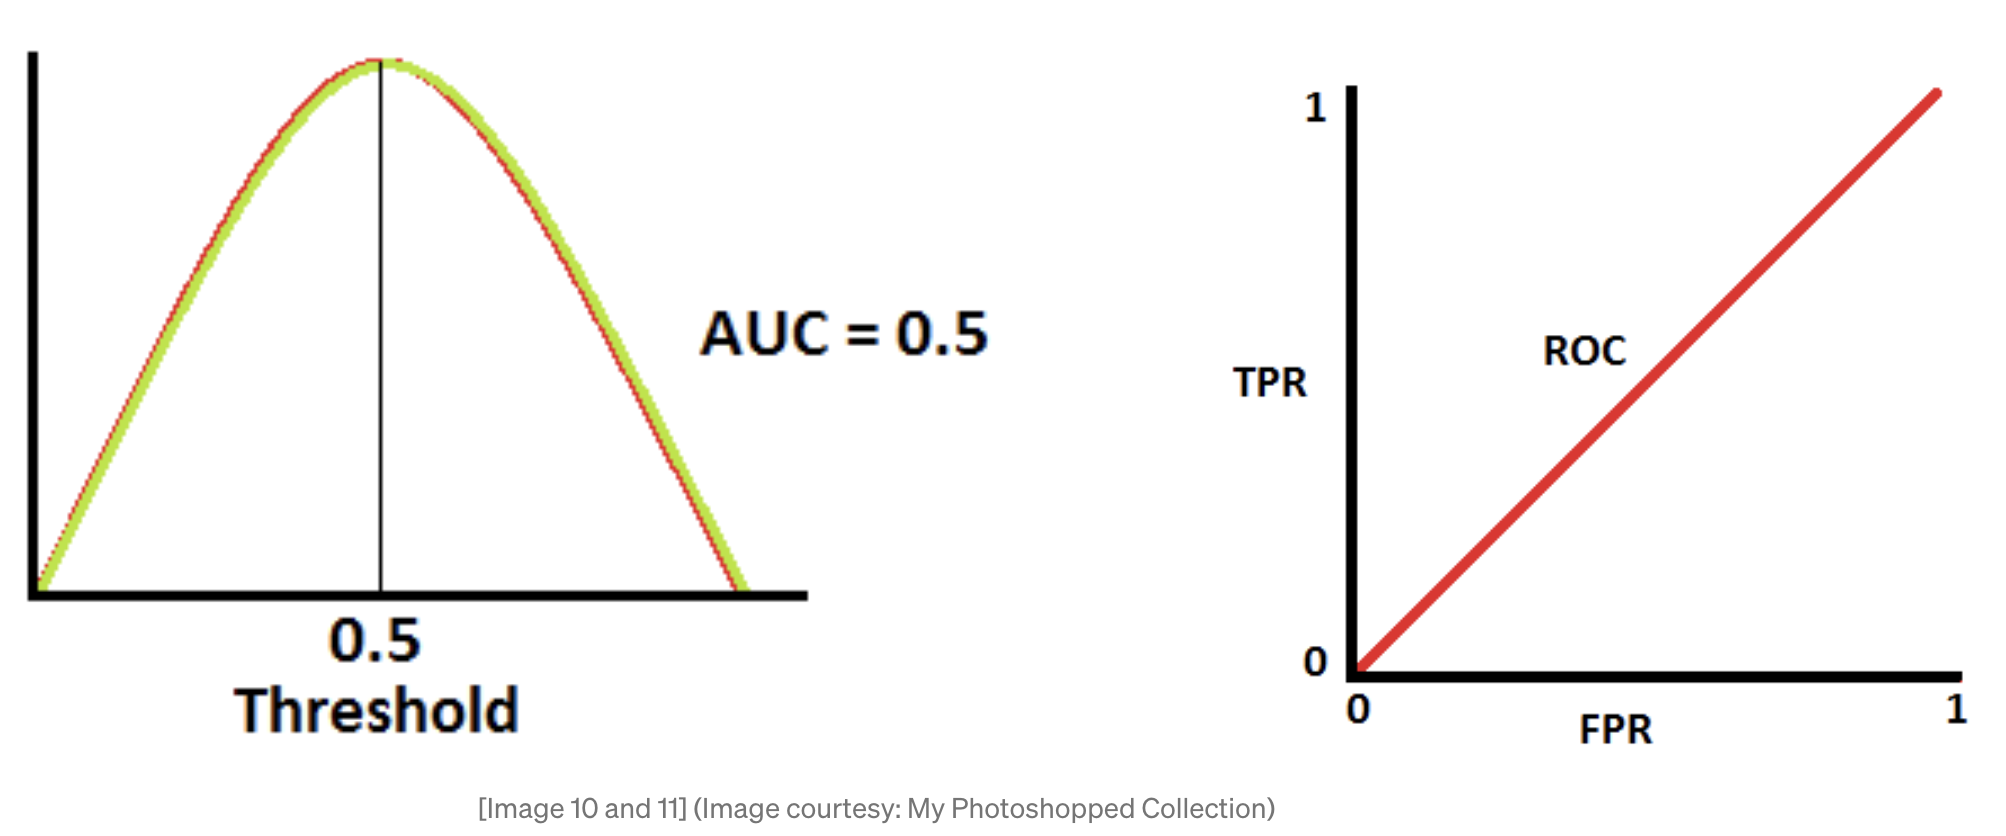

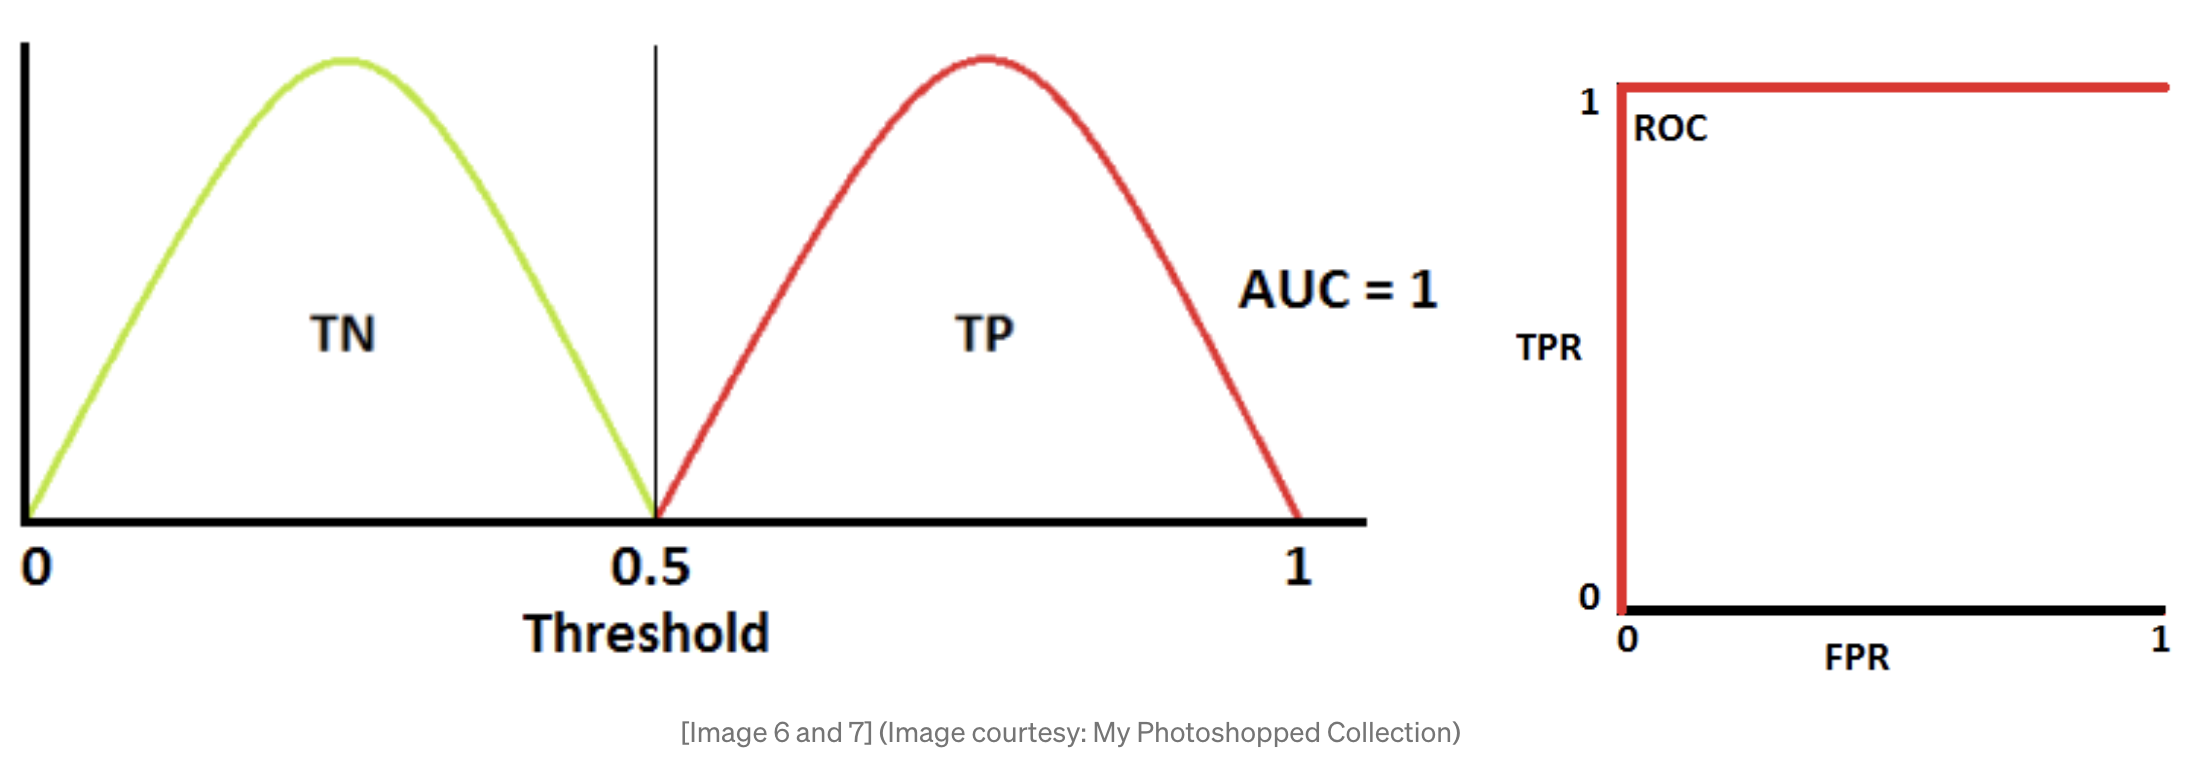

## Step 1 (Baseline)

### Logistic

In [24]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.84,NaN,12,NaN


In [25]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_1.csv', index=False)

Training ROC AUC: 0.993


In [26]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 1, 'Kaggle Score'] = 0.659
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.84,0.659,12,NaN


### KNeighbors

In [27]:
# Instantiate model
model = KNeighborsClassifier()

# Set parameters for CV
params = {
    'n_neighbors': list(range(2, 10)),
    'p': [1, 2],
    'leaf_size': [5, 10, 15], 
    'weights': ['uniform', 'distance']}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 6, 'leaf_size': 10}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,NaN,72,NaN


Woah, I was expecting KNN to perform slightly better than Logit for train and test, but I didn't expect its specificity score to go up so much!

While ROC_AUC is important, specificity is quite important for us too, as we want to conservatively know whether a trap has WMV-positive mosquitoes. So, at this juncture, I would pick KNN over Logit despite some evidence of overfitting. Let's move on to Random Forests to see if it performs better...

In [28]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 9, 'leaf_size': 5}
best_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2,
    n_neighbors = 9,
    leaf_size = 5
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_2.csv', index=False)

Training ROC AUC: 1.000


In [29]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 2, 'Kaggle Score'] = 0.593
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN


### Random Forest

In [30]:
# Instantiate model
model = RandomForestClassifier(random_state = 42)

# Set parameters for CV
params = {
    'n_estimators': [10, 20, 50, 100, 150, 200],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 20, 'min_samples_leaf': 2, 'max_features': None}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,NaN,37,NaN


Random Forest sucks. Performs worse than Logit and KNN, in terms of test ROC_AUC, and also Sensitivity. Overfitting is also evident, because the train ROC_AUC is near perfect but test ROC_AUC is so much lower.

In [31]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': None}
best_model = RandomForestClassifier(
    random_state = 42,
    n_estimators = 200,
    min_samples_leaf = 2,
    max_features = None
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_3.csv', index=False)

Training ROC AUC: 0.999


In [32]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 3, 'Kaggle Score'] = 0.689
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN


### Extra Trees

In [33]:
# Instantiate model
model = ExtraTreesClassifier(random_state = 42)

# Set parameters for CV
params = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [None, 3, 5, 7], #def: None
    'min_samples_split': [2, 3, 4, 5], #def:2, minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5] #def:1, minimum number of samples required to be at a leaf node
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': None}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,NaN,59,NaN


Random Forest sucks. Performs worse than Logit and KNN, in terms of test ROC_AUC, and also Sensitivity. Overfitting is also evident, because the train ROC_AUC is near perfect but test ROC_AUC is so much lower.

In [34]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None}
best_model = ExtraTreesClassifier(
    n_estimators = 1_000,
    min_samples_split = 4,
    min_samples_leaf = 1,
    max_depth = None
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_4.csv', index=False)

Training ROC AUC: 1.000


In [35]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 4, 'Kaggle Score'] = 0.708
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN


### Support Vector Machines

In [36]:
# Instantiate model
model = SVC(
    max_iter = 10_000,
    kernel = 'rbf',
    random_state = 42
)

# Set parameters for CV
params = {
    'C': np.linspace(0.0001, 1, 20)
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 1.0}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,NaN,195,NaN


Support Vector works better than RandomForest and  KNeighbours, but slighly underperform Logit. However, it's sensitivity score is much higher than Logit, so i would prefer it more. Let's see how it performs on Kaggle vis-a-vis Logit Regression.

In [37]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: Best Parameters: {'C': 0.8947473684210527}
best_model = SVC(
    max_iter = 10_000,
    kernel = 'rbf',
    random_state = 42,
    C = 0.8947473684210527
)

# Fit it 
best_model.fit(Z_sm, y_sm)
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
# y_pred = best_model.predict_proba(Z_kaggle)[:,1]
y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_5.csv', index=False)

Training ROC AUC: 0.889


In [38]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 5, 'Kaggle Score'] = 0.606
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN


### XGBoost

In [39]:
df_results = df_results[:5]

In [40]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[09:59:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 0.75, 'max_depth': 11, 'learning_rate': 0.3}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,NaN,105,NaN


I think XGBoost got chance to beat Logit model, as its test AUC score is slighly lower than Logit's but quite close. Sensitivity is also higher than Logit.

In [41]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 5, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 5, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
# y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_6.csv', index=False)

[09:59:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.997


In [42]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 6, 'Kaggle Score'] = 0.712
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN


## Step 2 (Fine-tuning)

In this section, we shortlist two models from Section 1 to do further fine-tuning
- Model 1 (logistic regression) has the best test/validation score and the second highest 5-fold CV score from the train set. 
- Model 6 (XGBoost) has the best 5-fold CV score and the highest Kaggle score, while maintaining a respectable test/validation score.

We proceed to fine tune Models 1 and 6 in this section.

### Logistic 


In [43]:
# Instantiate model
model = LogisticRegression(
    random_state = 42
)

# Set parameters for CV
params = {
    'solver' : ['liblinear', 'saga'], 
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 100],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 11}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,NaN,287,NaN


The hyperparameter tuning did not change the penalty choice (still l2) and the choice of C changed from 10 to 7. However, the CV score and train score stayed unchanged while the test score dropped from 0.840 to 0.835. This is strange. Let's see if the Kaggle score does better.

In [44]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 7}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 7
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_7.csv', index=False)

Training ROC AUC: 0.993


In [45]:
# Add comments to Remarks column
df_results.loc[df_results['Model No.'] == 7, 'Kaggle Score'] = 0.662
df_results.loc[df_results['Model No.'] == 7, 'Remarks'] = 'Cousin of Model 1, a lot of tuning'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"


The Kaggle score for Model 6 is improved over Model 1, so finetuning seems to work.

### XGBoost 

In [46]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8], 
    'subsample' : [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9], 
    'reg_alpha' : [0, 1, 1.5, 2, 2.5],
    'reg_lambda' : [1, 2, 3, 4, 5],
    'gamma' : [0.01, 0.02, 0.03, 0.04, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.85, 'reg_lambda': 1, 'reg_alpha': 1.5, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.01, 'eval_metric': 'auc'}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,NaN,106,NaN


Results are mixed. Model 8's CV score is unchanged, the train score is higher than Model 6's (which may be a sign of overfitting) and true enough, its test score is lower than Model 6 (0.800 vs 0.835). This means that extreme fine-tuning the XGBoost model will result in overfitting. Let's see if this is true when the model is submitted to Kaggle.

In [47]:
## Create Kaggle submission file, but refit best model on full Train set

# {'subsample': 0.85, 'reg_lambda': 4, 'reg_alpha': 0, 'max_depth': 7, 'learning_rate': 0.8, 'gamma': 0.04, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.85,
    reg_lambda = 4, 
    reg_alpha = 0, 
    max_depth = 7, 
    learning_rate = 0.8, 
    gamma = 0.04,                   
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
# y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_8.csv', index=False)

[10:06:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.999


In [48]:
# Add comments to Remarks column
df_results.loc[df_results['Model No.'] == 8, 'Remarks'] = 'Cousin of Model 6, a lot of tuning'
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 8, 'Kaggle Score'] = 0.700
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"


This shows that Model 8 is overfitted when I tuned XGBoost with a lot more hyperparameters, as its test score and Kaggle score is lower than Model 6's. It is best to stick to a model with fewer tuned parameters (i.e. Model 6) or a simpler model period (Model 1).

## Step 3 (Drop months)

As seen in the EDA section, month of the year has a high correlation (>0.9) to week of the year. This is true by defintion but we included both variables because there is predictive value in month of the year and it may outweight the issues caused by collinearity. This section investigates whether the trade-off is worth it.

In [49]:
# Find columns with Date_month and WetBulb
cols_to_drop = []
for _ in Z.columns:
    if 'Date_month' in _:
        cols_to_drop.append(_)
    if 'WetBulb' in _:
        cols_to_drop.append(_)
    if 'Tavg' in _:
        cols_to_drop.append(_)   
    if 'Tmin' in _:
        cols_to_drop.append(_)           
    if 'Tmax' in _:
        cols_to_drop.append(_) 
    if 'DewPoint' in _:
        cols_to_drop.append(_) 
    if 'PrecipTotal' in _:
        cols_to_drop.append(_) 
        
cols_to_drop

['Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'PrecipTotal',
 'Tmax_lag1',
 'Tmax_lag2',
 'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
 'Tmin_lag1',
 'Tmin_lag2',
 'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
 'Tavg_lag1',
 'Tavg_lag2',
 'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
 'DewPoint_lag1',
 'DewPoint_lag2',
 'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
 'WetBulb_lag1',
 'WetBulb_lag2',
 'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
 'PrecipTotal_lag1',
 'PrecipTotal_lag2',
 'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10']

In [50]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
#  'Tmax_lag4',
#  'Tmax_lag5',
#  'Tmax_lag6',
#  'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
#  'Tmin_lag4',
#  'Tmin_lag5',
#  'Tmin_lag6',
#  'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
#  'Tavg_lag4',
#  'Tavg_lag5',
#  'Tavg_lag6',
#  'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
#  'DewPoint_lag4',
#  'DewPoint_lag5',
#  'DewPoint_lag6',
#  'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
#  'WetBulb_lag4',
#  'WetBulb_lag5',
#  'WetBulb_lag6',
#  'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
#  'PrecipTotal_lag4',
#  'PrecipTotal_lag5',
#  'PrecipTotal_lag6',
#  'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10'
]

In [51]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 219), (2119, 219), (16036, 219), (116293, 219))

In [52]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 213), (2119, 213), (16036, 213), (116293, 213))

### Logistic 

In [53]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,NaN,40,NaN


Dropping month of the year seems to result in poorer performance, as the test score is lower.

In [54]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 9}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 9
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_9.csv', index=False)

Training ROC AUC: 0.993


In [55]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 9, 'Kaggle Score'] = 0.653
df_results.loc[df_results['Model No.'] == 9, 'Remarks'] = 'Drop month, weather lagged 7 days'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"


Dropping month of the year is indeed bad for the Logistic model. Both Kaggle score and test score are lower than Model 1 and Model 7, while CV score is the same. This means that althought `month` is highly correlated to `week`, its predictive value outweighs collinearity issues. Let's see if this is true for XGBoost.

### XGBoost 

In [56]:
df_results = df_results[:9]

In [57]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[10:09:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 15, 'learning_rate': 0.3}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,NaN,135,NaN


Model 10 seems to perform worse than Model 6, as its test score is lower even as its train score is higher than Model 6, which means Model 10 is overfitted. 

In [58]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'max_depth': 13, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    max_depth = 13, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_10.csv', index=False)

[10:09:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 1.000


In [59]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 10, 'Kaggle Score'] = 0.673
df_results.loc[df_results['Model No.'] == 10, 'Remarks'] = 'Drop month, weather lagged 7 days'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Same issue with Kaggle scoring - Model 10's Kaggle score is lower than Model 6's and even Model 7's, so this is a clear sign that removing a correlated variable like `month` is bad for model prediction. We shall retain the variable in subsequent tests.

## Step 4 (Weather lag 3)

Despite the life cycle of mosquitoes being 7 days, it may be worth reducing some columns as lagged values of WetBulb, Temperature, DewPoint and PrecipTotal are highly correlated between days. In this section, we reduce the lagged weather variables from 7 days to 3 days.

In [60]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
#  'Date_month_5',
#  'Date_month_6',
#  'Date_month_7',
#  'Date_month_8',
#  'Date_month_9',
#  'Date_month_10'
]

In [61]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 219), (2119, 219), (16036, 219), (116293, 219))

In [62]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 195), (2119, 195), (16036, 195), (116293, 195))

### Logistic 

In [63]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 11}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


On the surface, nothing much changed with the drop of weather values that are lagged 4, 5, 6, 7 days. Test and CV scores are similar. Let's check Kaggle scoring.

In [64]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 8
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_11.csv', index=False)

Training ROC AUC: 0.993


In [65]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 11, 'Kaggle Score'] = 0.717
df_results.loc[df_results['Model No.'] == 11, 'Remarks'] = 'Drop month, weather lagged 3 days'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Wow, the Kaggle score jumped a lot, from 0.659 to 0.717. This means that previous versions of the Logistic models are likely to be overfitted to the presence of so many lagged weather variables. Let's see if this observation is true for XGBoost.

### XGBoost 

In [66]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[10:12:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 13, 'learning_rate': 0.5}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


This looks promising. Model 12 has the highest CV score amongst all XGBoost models, and also the highest test scores.

In [67]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'max_depth': 15, 'learning_rate': 0.3}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    max_depth = 15, 
    learning_rate = 0.3                      
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_12.csv', index=False)

[10:12:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 1.000


In [68]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 12, 'Kaggle Score'] = 0.713
df_results.loc[df_results['Model No.'] == 12, 'Remarks'] = 'Drop month, weather lagged 3 days'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Removing weather values that are lagged 4, 5, 6, 7 days bring about bring improvements in scoring for both Logistic and XGBoost models. The Kaggle scores are now over 71%. 

Out of interest, we want to see if further reducing the number of lagged weather variables will continue to bring about improvements in performance. Perhaps the life cycle of mosquitoes do not matter at all...

## Step 5 (Weather lag 1)

In [69]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
 'Tmax_lag2',
 'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
 'Tavg_lag2',
 'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
 'DewPoint_lag2',
 'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
 'WetBulb_lag2',
 'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
 'PrecipTotal_lag2',
 'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
#  'Date_month_5',
#  'Date_month_6',
#  'Date_month_7',
#  'Date_month_8',
#  'Date_month_9',
#  'Date_month_10'
]

In [70]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 219), (2119, 219), (16036, 219), (116293, 219))

In [71]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 185), (2119, 185), (16036, 185), (116293, 185))

### Logistic 

In [72]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 9}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Interesting, performance drops when the lag is reduced. This means that there is decent amount of predictive value in lag=2 and lag=3.

In [73]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 18
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_13.csv', index=False)

Training ROC AUC: 0.992


In [74]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 13, 'Kaggle Score'] = 0.732
df_results.loc[df_results['Model No.'] == 13, 'Remarks'] = 'Drop month, weather lagged 1 day'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Hmm...the results are inconclusive. CV, train and test scores drop across the board. However the Kaggle score increase but it could be a fluke. Let's confirm with XGBoost.

### XGBoost 

In [75]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[10:13:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 13, 'learning_rate': 0.7}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Like logistic regression, XGBoost performance is degraded when weather lag is reduced from 3 days to to 1 day. 

In [76]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 7, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 7, 
    learning_rate = 0.7                      
)


# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_14.csv', index=False)

[10:13:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.999


In [77]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 14, 'Kaggle Score'] = 0.676
df_results.loc[df_results['Model No.'] == 14, 'Remarks'] = 'Drop month, weather lagged 1 day'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Kaggle score is also lower for XGBoost in Model 14, so we can quite confidently conclude that weather variables that are lagged 2 and 3 days are important.

## Step 6 (KMeans)


We shall now attempt to create clusters of neighborhoods, instead of using Latitude / Longitude or Trap IDs, to address two potential issues:
- Latitude / Longitude are continuous variables but on the ground, they may not imply linear relationships with respect to the presence of WNV, which might appear in blobs of clusters as seen during EDA
- There are more Trap IDs found in Test set than Train set, so one-hot encoding will result in lousier prediction for those 13 Trap IDs that are not seen and fitted in the Train set.

In the subsequent sections, we will create mozzie 'clusters' by using 4 variables: `   'Latitude', 'Longitude', 'WnvPresent', 'NumMosquitos'`. KMeans algorithm will be used to assign cluster values based on proximity to these 4 variables. As seen earlier, the Kaggle test has Trap IDs and/or Longitude-Latitude coordinates that are not seen in the train set. For these locations, we will use KNeighborsClassifer to predict which mozzie cluster they should belong to.

### Create 'mozzie' clusters 

In [78]:
# Set up X and Z
X_clusters = train[[
       'Latitude', 'Longitude', 
       'WnvPresent', 'NumMosquitos'
]].groupby([
       'Latitude','Longitude'
]).mean().reset_index()
# X_clusters = train[['Latitude', 'Longitude', 'WnvPresent']]

ss = StandardScaler()
Z_clusters = ss.fit_transform(X_clusters)
Z_clusters = pd.DataFrame(Z_clusters, columns = X_clusters.columns)

In [79]:
# Instantiate and fit KMeans()
km = KMeans(n_clusters = 5)
km.fit(Z_clusters)
X_clusters['cluster_km'] = km.labels_
# Z_clusters['cluster_km'] = km.labels_

# Instantiate and fit DBSCAN()
db = DBSCAN(eps = 0.5, min_samples = 5)
db.fit(Z_clusters)
X_clusters['cluster_db'] = db.labels_
# Z_clusters['cluster_db'] = db.labels_

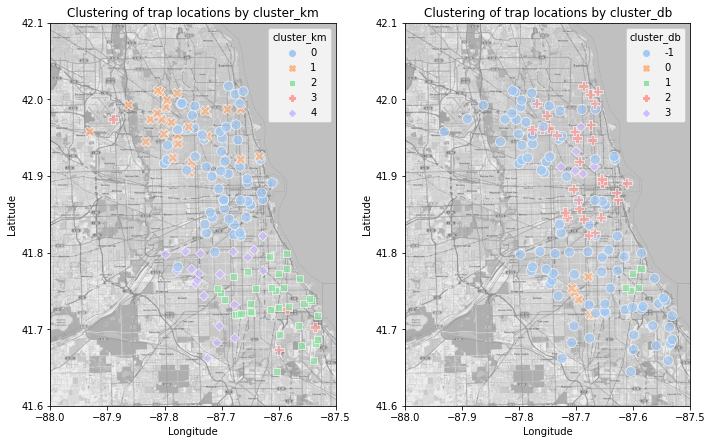

In [80]:
# Plot both map, clustered by KMeans and DBSCAN

mapdata = np.loadtxt("../data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,14))

clusters = ['cluster_km', 'cluster_db']

for cluster_type, axes in zip(clusters, axes.flat):
  axes.imshow(mapdata, 
            cmap=plt.get_cmap('gray'), 
            extent=lon_lat_box, 
            aspect=aspect)

  sns.scatterplot(
      data = X_clusters,
      x = 'Longitude',
      y = 'Latitude',
      hue = cluster_type,
      style = cluster_type,
      s = 100,
      alpha = 0.7,
      palette = "pastel",
      ax = axes
  );
  plt.tight_layout()
  axes.title.set_text(f'Clustering of trap locations by {cluster_type}')




### Add features using KMeans

In [81]:
# Create custom function to add clustered neighborhood and drop some columns
def add_cluster(df):
    df_clustered = pd.merge(
        left = df, 
    # right = X_clusters.drop_duplicates(subset = ['Latitude', 'Longitude']),
        right = X_clusters,
        how = 'left',
        on = ['Latitude', 'Longitude']
    ).drop(
        columns = cols_to_drop
    )
    return df_clustered

In [82]:
# Recreate X and Y
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [83]:
## Create X_train_clustered, X_test_clustered, X_clustered, X_kaggle_clustered

# Drops columns
cols_to_drop = [
#  'cluster_km',
 'cluster_db',
#  'Date_month',
 'WnvPresent',
 'NumMosquitos',  
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
]

# Create datasets with mozzie-neighborhood clusters
X_train_clustered = add_cluster(X_train)
X_test_clustered = add_cluster(X_test)
X_clustered = add_cluster(X)
X_kaggle_clustered = add_cluster(X_kaggle)

# Check
print(X_train.shape, X_train_clustered.shape)
print(X_test.shape, X_test_clustered.shape)
print(X.shape, X_clustered.shape)
print(test.shape, X_kaggle_clustered.shape)

(6356, 54) (6356, 31)
(2119, 54) (2119, 31)
(8475, 54) (8475, 31)
(116293, 54) (116293, 31)


In [84]:
# Check X_kaggle for missing values in cluster_km
# to be expected as there are traps in Test that are unseen in Train
X_kaggle_clustered.isnull().sum()

Species                0
Trap                   0
Latitude               0
Longitude              0
Date_month             0
                    ... 
PrecipTotal_lag1       0
PrecipTotal_lag2       0
PrecipTotal_lag3       0
Date_week              0
cluster_km          9905
Length: 31, dtype: int64

There are 9905 rows in the Kaggle set that couldn't be mapped. This means that those Traps or GPS coordinates were not seen in the train set. We now use KNeighborsClassifier, setting n_neighbors = 1 by Euclidean measurement, to predict which cluster they should belong to.

In [85]:
# Instantiate KNN to fit missing values of cluster_km in Kaggle test set
cluster_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2, # Euclidean
    n_neighbors = 1
)

# Instantiate SS to standardize GPS coordinates
ss = StandardScaler()

# Fit it 
cluster_model.fit(
    ss.fit_transform(X_clusters[['Latitude','Longitude']]), 
    X_clusters['cluster_km']
)

# Check model score, should give near 100% accuracy
cluster_model.score(ss.transform(X_clusters[['Latitude','Longitude']]), X_clusters['cluster_km'])

1.0

In [86]:
# Create predicted values of clusters
X_kaggle_clustered['pred'] = cluster_model.predict(
    ss.transform(X_kaggle_clustered[['Latitude','Longitude']])
)

# Check predictions
X_kaggle_clustered.loc[X_kaggle_clustered['cluster_km'].isnull(),'pred'].unique()

array([4, 0, 2, 1], dtype=int32)

Missing traps seem be to all over the city, no specific area that they are missing from.

In [87]:
# Overwrite missing cluster_km

def replace_cluster(x):
    if np.isnan(x.cluster_km):
        return x.pred
    else:
        return x.cluster_km

# Impute values
X_kaggle_clustered['cluster_km'] = X_kaggle_clustered.apply(lambda x: replace_cluster(x), axis = 1)
# X_kaggle_clustered['cluster_km'] = X_kaggle_clustered.apply(
#     lambda x: x.pred if np.isnan(x.cluster_km) else x.cluster_km
# )

# Check that all missing values are filled with predicted values
X_kaggle_clustered.isnull().sum()

Species             0
Trap                0
Latitude            0
Longitude           0
Date_month          0
                   ..
PrecipTotal_lag2    0
PrecipTotal_lag3    0
Date_week           0
cluster_km          0
pred                0
Length: 32, dtype: int64

In [88]:
# Check again
X_kaggle_clustered.drop(columns = 'pred', inplace = True)
X_kaggle_clustered['cluster_km'].unique()

array([1., 0., 4., 2., 3.])

Good, all values are present

In [89]:
# Drop Longitude and Latitude, in favor of cluster_km
X_train_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_test_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_kaggle_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)

In [90]:
# Check
X_train_clustered

,Species,Trap,Date_month,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tavg_lag1,Tavg_lag2,Tavg_lag3,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,Date_week,cluster_km
0,CULEX PIPIENS/RESTUANS,T115,6,68.0,60.0,64.0,55.5,59.0,0.00,71.5,74.0,89.0,62.5,65.0,67.5,67.5,70.0,78.5,59.5,62.5,70.0,62.5,65.0,72.5,0.030,0.020,0.265,25,3
1,CULEX RESTUANS,T225,7,86.5,70.5,78.5,70.5,73.0,0.67,88.5,82.5,86.5,70.0,68.0,61.5,79.5,75.5,74.0,66.5,64.0,60.5,71.0,68.0,66.0,0.000,0.000,0.000,28,4
2,CULEX PIPIENS,T220,9,89.5,65.0,77.5,59.5,66.5,0.00,88.0,84.5,80.0,65.0,61.5,58.5,76.5,73.0,69.5,61.0,56.5,55.5,67.0,63.0,61.5,0.000,0.000,0.000,36,0
3,CULEX PIPIENS,T102,8,91.5,69.0,80.5,62.5,69.5,0.00,90.0,87.5,85.0,68.5,63.5,65.0,79.5,76.0,75.0,60.5,56.0,56.5,68.0,64.5,64.0,0.000,0.000,0.000,31,2
4,CULEX PIPIENS/RESTUANS,T025,8,91.5,69.0,80.5,62.5,69.5,0.00,90.0,87.5,85.0,68.5,63.5,65.0,79.5,76.0,75.0,60.5,56.0,56.5,68.0,64.5,64.0,0.000,0.000,0.000,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351,CULEX PIPIENS/RESTUANS,T225,8,78.5,67.0,73.0,55.5,62.0,0.00,90.0,84.0,75.5,68.5,67.5,60.5,79.5,76.0,68.5,67.5,66.5,57.5,71.0,69.5,61.5,0.005,0.020,0.045,32,4
6352,CULEX PIPIENS/RESTUANS,T900,8,67.0,61.5,64.5,60.5,62.0,1.07,72.5,82.5,79.0,63.0,60.0,55.5,68.0,71.5,67.5,63.0,61.0,56.5,64.5,65.0,61.5,0.735,0.000,0.000,35,3
6353,CULEX RESTUANS,T128,6,60.5,49.0,55.0,46.5,50.5,0.09,79.0,72.5,79.0,51.5,47.0,51.5,65.5,60.0,65.5,53.5,42.0,46.0,57.5,51.0,54.5,0.635,0.000,0.000,23,2
6354,CULEX TERRITANS,T221,8,83.0,60.0,71.5,58.0,63.5,0.00,81.5,91.5,73.5,64.5,69.5,64.0,73.5,81.0,69.0,59.0,65.0,62.5,64.0,70.0,65.0,0.000,0.000,0.525,34,2


In [91]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_week', 'Date_month', 'cluster_km']
continuous_cols = [col for col in X_clustered.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train_clustered = mapper.fit_transform(X_train_clustered)
Z_test_clustered = mapper.transform(X_test_clustered)

# Create Z_ data set for Kaggle, refitted based on full train set
Z_clustered = mapper.fit_transform(X_clustered)
Z_kaggle_clustered = mapper.transform(X_kaggle_clustered)

In [92]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train_clustered.columns[:24]
cat_col_names = Z_train_clustered.columns[24:]
print(num_col_names, '\n\n', cat_col_names)

Index(['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmin_lag1', 'Tmin_lag2',
       'Tmin_lag3', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'DewPoint_lag1',
       'DewPoint_lag2', 'DewPoint_lag3', 'WetBulb_lag1', 'WetBulb_lag2',
       'WetBulb_lag3', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3'],
      dtype='object') 

 Index(['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Trap_T001', 'Trap_T002', 'Trap_T003',
       ...
       'Date_month_6', 'Date_month_7', 'Date_month_8', 'Date_month_9',
       'Date_month_10', 'cluster_km_0', 'cluster_km_1', 'cluster_km_2',
       'cluster_km_3', 'cluster_km_4'],
      dtype='object', length=174)


In [93]:
# Create column index-numbers of categorical
cat_col_index = list(range(len(num_col_names),len(Z_train_clustered.columns)))

In [94]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_clustered_sm, y_train_sm = sm.fit_resample(Z_train_clustered, y_train)

# Re-instantiate, for Kaggle submission purposes, 
# as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_clustered_sm, y_sm = sm.fit_resample(Z_clustered, y)

CPU times: user 34.1 s, sys: 527 ms, total: 34.7 s
Wall time: 34.9 s


In [95]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [96]:
# Check
Z_train_clustered.shape, Z_train_clustered_sm.shape

((6356, 198), (12026, 198))

In [97]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_clustered_sm = pd.DataFrame(Z_train_clustered_sm, columns = Z_train_clustered.columns)
display(Z_train_clustered_sm)

Z_clustered_sm = pd.DataFrame(Z_clustered_sm, columns = Z_clustered.columns)
display(Z_clustered_sm)

,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tavg_lag1,Tavg_lag2,Tavg_lag3,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,cluster_km_0,cluster_km_1,cluster_km_2,cluster_km_3,cluster_km_4
0,-1.594119,-0.414386,-1.122594,-0.484309,-0.795577,-0.462624,-1.208497,-0.785583,1.012977,-0.080830,0.309871,0.670165,-0.671845,-0.266953,0.901987,0.031520,0.503113,1.447464,-0.267650,0.178948,1.299682,-0.336896,-0.363120,0.722332,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0.609664,0.963762,0.790436,1.405126,1.255580,1.526073,0.960578,0.242464,0.714293,0.949019,0.742880,-0.188388,1.008115,0.495727,0.285134,0.903118,0.700910,0.207086,1.018090,0.656110,0.304841,-0.418017,-0.399946,-0.426461,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0.967034,0.241875,0.658503,0.019540,0.303257,-0.462624,0.896782,0.484358,-0.062284,0.262453,-0.195306,-0.617665,0.588125,0.149054,-0.331719,0.218291,-0.288075,-0.445745,0.413036,-0.139160,-0.383895,-0.418017,-0.399946,-0.426461,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1.205281,0.766884,1.054303,0.397427,0.742791,-0.462624,1.151967,0

,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tavg_lag1,Tavg_lag2,Tavg_lag3,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,cluster_km_0,cluster_km_1,cluster_km_2,cluster_km_3,cluster_km_4
0,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.504484,-0.681842,-1.872236,-1.007444,-0.738040,-1.814401,-1.376441,-1.393590,-0.488253,-1.155019,-1.155982,-1.123711,-0.416099,-0.288426,2.367833,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.504484,-0.681842,-1.872236,-1.007444,-0.738040,-1.814401,-1.376441,-1.393590,-0.488253,-1.155019,-1.155982,-1.123711,-0.416099,-0.288426,2.367833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.504484,-0.681842,-1.872236,-1.007444,-0.738040,-1.814401,-1.376441,-1.393590,-0.488253,-1.155019,-1.155982,-1.123711,-0.416099,-0.288426,2.367833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0.796179,-0.073249,0.404568,-0.0939

We have now finished preparing the data with clustered neighborhoods and dropping longitude/latitude coordinates. Time to see if the model performs better!

### Logistic

In [98]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}


# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 11}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


When compared to Model 11, which is the better performing logit model to date, Model 15 outperforms in every area! This is a positive development. Let's see if this is also true for Kaggle scoring.

In [99]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 8
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_15.csv', index=False)

Training ROC AUC: 0.993


In [100]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 15, 'Kaggle Score'] = 0.705
df_results.loc[df_results['Model No.'] == 15, 'Remarks'] = 'Cousin of Model 11, with KMeans mozzie clusters'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Kaggle score is lower than Model 11, but given that all other metrics are better, we shall reserve judgement until we see how it works for XGBoost.

### XGBoost

In [101]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[10:16:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 0.75, 'max_depth': 7, 'learning_rate': 0.5}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


This looks promising. The test score for Model 16 is higher than its GPS-coordinates cousin Model 12.

In [102]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 7, 'learning_rate': 0.3}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 7, 
    learning_rate = 0.3                      
)


# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_16.csv', index=False)

[10:16:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.996


In [103]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 16, 'Kaggle Score'] = 0.695
df_results.loc[df_results['Model No.'] == 16, 'Remarks'] = 'Cousin of Model 12, with KMeans mozzie clusters'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


With lower Kaggle score but higher test score, it is a toss-up. We can't confidently state that KMeans-derived clusters is better than GPS coordinates.

## Step 7 (DBSCAN)

In this section, we repeat what we did in earlier, except that we use a different algorithm DBSCAN to come up with mosquito clusters.


In the subsequent sections, we will create mozzie 'clusters' by using 4 variables: `   'Latitude', 'Longitude', 'WnvPresent', 'NumMosquitos'`. DSCAN algorithm will be used to assign cluster values based on proximity to these 4 variables. As seen earlier, the Kaggle test has Trap IDs and/or Longitude-Latitude coordinates that are not seen in the train set. For these locations, we will use KNeighborsClassifer to predict which mozzie cluster they should belong to.

In [104]:
# Must bring back Latitude, as it was dropped earlier
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [105]:
## Create X_train_clustered, X_test_clustered, X_clustered, X_kaggle_clustered

# Drops columns: cluster_db + others mentioned for Model 8
cols_to_drop = [
 'cluster_km',
#  'cluster_db',
#  'Date_month',
 'WnvPresent',
 'NumMosquitos',  
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
]

# Create datasets with mozzie-neighborhood clusters
X_train_clustered = add_cluster(X_train)
X_test_clustered = add_cluster(X_test)
X_clustered = add_cluster(X)
X_kaggle_clustered = add_cluster(X_kaggle)

# Check
print(X_train.shape, X_train_clustered.shape)
print(X_test.shape, X_test_clustered.shape)
print(X.shape, X_clustered.shape)
print(test.shape, X_kaggle_clustered.shape)

(6356, 54) (6356, 31)
(2119, 54) (2119, 31)
(8475, 54) (8475, 31)
(116293, 54) (116293, 31)


In [106]:
# Check X_kaggle for missing values in cluster_km
# to be expected as there are traps in Test that are unseen in Train
X_kaggle_clustered.isnull().sum()

Species                0
Trap                   0
Latitude               0
Longitude              0
Date_month             0
                    ... 
PrecipTotal_lag1       0
PrecipTotal_lag2       0
PrecipTotal_lag3       0
Date_week              0
cluster_db          9905
Length: 31, dtype: int64

There are 9905 rows in the Kaggle set that couldn't be mapped. This means that those Traps or GPS coordinates were not seen in the train set. We now use KNeighborsClassifier, setting n_neighbors = 1 by Euclidean measurement, to predict which cluster they should belong to.

In [107]:
# Instantiate KNN to fit missing values of cluster_km in Kaggle test set
cluster_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2, # Euclidean
    n_neighbors = 1
)

# Instantiate SS to standardize GPS coordinates
ss = StandardScaler()

# Fit it 
cluster_model.fit(
    ss.fit_transform(X_clusters[['Latitude','Longitude']]), 
    X_clusters['cluster_db']
)

# Check model score, should give near 100% accuracy
cluster_model.score(ss.transform(X_clusters[['Latitude','Longitude']]), X_clusters['cluster_db'])

1.0

In [108]:
# Create predicted values of clusters
X_kaggle_clustered['pred'] = cluster_model.predict(
    ss.transform(X_kaggle_clustered[['Latitude','Longitude']])
)

# Check predictions
X_kaggle_clustered.loc[X_kaggle_clustered['cluster_db'].isnull(),'pred'].unique()

array([-1,  2])

DBSCAN clusters '-1' and '2' are found all over the city, no specific area that they are missing from.

In [109]:
# Overwrite missing cluster_km
def replace_cluster(x):
    if np.isnan(x.cluster_db):
        return x.pred
    else:
        return x.cluster_db

# Impute values
X_kaggle_clustered['cluster_db'] = X_kaggle_clustered.apply(lambda x: replace_cluster(x), axis = 1)

# Check
X_kaggle_clustered.isnull().sum()

Species             0
Trap                0
Latitude            0
Longitude           0
Date_month          0
                   ..
PrecipTotal_lag2    0
PrecipTotal_lag3    0
Date_week           0
cluster_db          0
pred                0
Length: 32, dtype: int64

In [110]:
# Check again
X_kaggle_clustered.drop(columns = 'pred', inplace = True)
X_kaggle_clustered['cluster_db'].unique()

array([-1.,  2.,  3.,  0.,  1.])

In [111]:
# Drop Longitude and Latitude, in favor of cluster_km
X_train_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_test_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_kaggle_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)

In [112]:
# Check
X_clustered

,Species,Trap,Date_month,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tavg_lag1,Tavg_lag2,Tavg_lag3,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,Date_week,cluster_db
0,CULEX PIPIENS/RESTUANS,T048,5,88.0,62.5,75.5,58.5,65.5,0.0,77.5,75.0,67.5,52.0,58.0,49.5,65.0,66.50,58.5,48.0,48.0,55.0,56.5,56.5,56.5,0.0,0.06,0.645,22,-1
1,CULEX RESTUANS,T048,5,88.0,62.5,75.5,58.5,65.5,0.0,77.5,75.0,67.5,52.0,58.0,49.5,65.0,66.50,58.5,48.0,48.0,55.0,56.5,56.5,56.5,0.0,0.06,0.645,22,-1
2,CULEX RESTUANS,T091,5,88.0,62.5,75.5,58.5,65.5,0.0,77.5,75.0,67.5,52.0,58.0,49.5,65.0,66.50,58.5,48.0,48.0,55.0,56.5,56.5,56.5,0.0,0.06,0.645,22,-1
3,CULEX RESTUANS,T049,5,88.0,62.5,75.5,58.5,65.5,0.0,77.5,75.0,67.5,52.0,58.0,49.5,65.0,66.50,58.5,48.0,48.0,55.0,56.5,56.5,56.5,0.0,0.06,0.645,22,2
4,CULEX RESTUANS,T153,5,88.0,62.5,75.5,58.5,65.5,0.0,77.5,75.0,67.5,52.0,58.0,49.5,65.0,66.50,58.5,48.0,48.0,55.0,56.5,56.5,56.5,0.0,0.06,0.645,22,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,CULEX PIPIENS,T138,9,75.0,52.5,64.0,52.0,58.0,0.0,70.5,80.5,67.0,53.5,50.5,48.0,62.5,65.75,58.0,51.5,48.5,46.5,56.0,54.0,52.5,0.0,0.00,0.000,39,-1
8471,CULEX PIPIENS/RESTUANS,T138,9,75.0,52.5,64.0,52.0,58.0,0.0,70.5,80.5,67.0,53.5,50.5,48.0,62.5,65.75,58.0,51.5,48.5,46.5,56.0,54.0,52.5,0.0,0.00,0.000,39,-1
8472,CULEX PIPIENS/RESTUANS,T089,9,75.0,52.5,64.0,52.0,58.0,0.0,70.5,80.5,67.0,53.5,50.5,48.0,62.5,65.75,58.0,51.5,48.5,46.5,56.0,54.0,52.5,0.0,0.00,0.000,39,-1
8473,CULEX PIPIENS/RESTUANS,T090,9,75.0,52.5,64.0,52.0,58.0,0.0,70.5,80.5,67.0,53.5,50.5,48.0,62.5,65.75,58.0,51.5,48.5,46.5,56.0,54.0,52.5,0.0,0.00,0.000,39,-1


In [113]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_week', 'Date_month', 'cluster_db']
continuous_cols = [col for col in X_clustered.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train_clustered = mapper.fit_transform(X_train_clustered)
Z_test_clustered = mapper.transform(X_test_clustered)

# Create Z_ data set for Kaggle, refitted based on full train set
Z_clustered = mapper.fit_transform(X_clustered)
Z_kaggle_clustered = mapper.transform(X_kaggle_clustered)

In [114]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train_clustered.columns[:24]
cat_col_names = Z_train_clustered.columns[24:]
print(num_col_names, '\n\n', cat_col_names)

Index(['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmin_lag1', 'Tmin_lag2',
       'Tmin_lag3', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'DewPoint_lag1',
       'DewPoint_lag2', 'DewPoint_lag3', 'WetBulb_lag1', 'WetBulb_lag2',
       'WetBulb_lag3', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3'],
      dtype='object') 

 Index(['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Trap_T001', 'Trap_T002', 'Trap_T003',
       ...
       'Date_month_6', 'Date_month_7', 'Date_month_8', 'Date_month_9',
       'Date_month_10', 'cluster_db_-1', 'cluster_db_0', 'cluster_db_1',
       'cluster_db_2', 'cluster_db_3'],
      dtype='object', length=174)


In [115]:
# Create column index-numbers of categorical
cat_col_index = list(range(len(num_col_names),len(Z_train_clustered.columns)))

In [116]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_clustered_sm, y_train_sm = sm.fit_resample(Z_train_clustered, y_train)

# Re-instantiate, for Kaggle submission purposes, 
# as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_clustered_sm, y_sm = sm.fit_resample(Z_clustered, y)

CPU times: user 34.3 s, sys: 465 ms, total: 34.8 s
Wall time: 35.1 s


In [117]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [118]:
# Check
Z_train_clustered.shape, Z_train_clustered_sm.shape

((6356, 198), (12026, 198))

In [119]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_clustered_sm = pd.DataFrame(Z_train_clustered_sm, columns = Z_train_clustered.columns)
display(Z_train_clustered_sm)

Z_clustered_sm = pd.DataFrame(Z_clustered_sm, columns = Z_clustered.columns)
display(Z_clustered_sm)

,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tavg_lag1,Tavg_lag2,Tavg_lag3,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,cluster_db_-1,cluster_db_0,cluster_db_1,cluster_db_2,cluster_db_3
0,-1.594119,-0.414386,-1.122594,-0.484309,-0.795577,-0.462624,-1.208497,-0.785583,1.012977,-0.080830,0.309871,0.670165,-0.671845,-0.266953,0.901987,0.031520,0.503113,1.447464,-0.267650,0.178948,1.299682,-0.336896,-0.363120,0.722332,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0.609664,0.963762,0.790436,1.405126,1.255580,1.526073,0.960578,0.242464,0.714293,0.949019,0.742880,-0.188388,1.008115,0.495727,0.285134,0.903118,0.700910,0.207086,1.018090,0.656110,0.304841,-0.418017,-0.399946,-0.426461,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0.967034,0.241875,0.658503,0.019540,0.303257,-0.462624,0.896782,0.484358,-0.062284,0.262453,-0.195306,-0.617665,0.588125,0.149054,-0.331719,0.218291,-0.288075,-0.445745,0.413036,-0.139160,-0.383895,-0.418017,-0.399946,-0.426461,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1.205281,0.766884,1.054303,0.397427,0.742791,-0.462624,1.151967,

,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,Tmax_lag1,Tmax_lag2,Tmax_lag3,Tmin_lag1,Tmin_lag2,Tmin_lag3,Tavg_lag1,Tavg_lag2,Tavg_lag3,DewPoint_lag1,DewPoint_lag2,DewPoint_lag3,WetBulb_lag1,WetBulb_lag2,WetBulb_lag3,PrecipTotal_lag1,PrecipTotal_lag2,PrecipTotal_lag3,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Date_week_22,Date_week_23,Date_week_24,Date_week_25,Date_week_26,Date_week_27,Date_week_28,Date_week_29,Date_week_30,Date_week_31,Date_week_32,Date_week_33,Date_week_34,Date_week_35,Date_week_36,Date_week_37,Date_week_38,Date_week_39,Date_week_40,Date_week_41,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,cluster_db_-1,cluster_db_0,cluster_db_1,cluster_db_2,cluster_db_3
0,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.504484,-0.681842,-1.872236,-1.007444,-0.738040,-1.814401,-1.376441,-1.393590,-0.488253,-1.155019,-1.155982,-1.123711,-0.416099,-0.288426,2.367833,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.504484,-0.681842,-1.872236,-1.007444,-0.738040,-1.814401,-1.376441,-1.393590,-0.488253,-1.155019,-1.155982,-1.123711,-0.416099,-0.288426,2.367833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.796179,-0.073249,0.404568,-0.093933,0.167949,-0.458229,-0.434930,-0.655841,-1.540478,-1.504484,-0.681842,-1.872236,-1.007444,-0.738040,-1.814401,-1.376441,-1.393590,-0.488253,-1.155019,-1.155982,-1.123711,-0.416099,-0.288426,2.367833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0.796179,-0.073249,0.404568,-0.093

### Logistic

In [120]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}


# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Like KMeans clustering, DBSCAN clustering allows us to beat Model 11 on all metrics (average CV score, train score, test score). It looks like DBSCAN couuld be a better algorithm for mapping mozzie zones. Onward to Kaggle scorring...fingers crossed!

In [121]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_17.csv', index=False)

Training ROC AUC: 0.993


In [122]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 17, 'Kaggle Score'] = 0.717
df_results.loc[df_results['Model No.'] == 17, 'Remarks'] = 'Cousin of Model 11, with DBSCAN mozzie clusters'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Model 17 is the best logistic model to date, which highest scores in all categories. DBSCAN is a better clustering algorithm than KMeans, which is in turn better than using plain GPS coordinates. 

### XGBoost

In [123]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[10:19:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 0.75, 'max_depth': 15, 'learning_rate': 0.7}


,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Performance does not seem to differ too much between Model 16 and Model 18. 

In [124]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 13, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 13, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_18.csv', index=False)

[10:19:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.999


In [125]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 18, 'Kaggle Score'] = 0.722
df_results.loc[df_results['Model No.'] == 18, 'Remarks'] = 'Cousin of Model 12, with DBSCAN mozzie clusters'
df_results

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.840,0.659,12,NaN
0,2,KNeighborsClassifier(),0.916,1.000,0.794,0.593,72,NaN
0,3,RandomForestClassifier(random_state=42),0.981,0.999,0.777,0.689,37,NaN
0,4,ExtraTreesClassifier(random_state=42),0.957,0.973,0.831,0.708,59,NaN
0,5,"SVC(max_iter=10000, random_state=42)",0.974,0.981,0.829,0.606,195,NaN
0,6,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.822,0.712,105,NaN
0,7,LogisticRegression(random_state=42),0.989,0.994,0.841,0.662,287,"Cousin of Model 1, a lot of tuning"
0,8,"XGBClassifier(base_score=None, booster=None, c...",0.991,1.000,0.817,0.7,106,"Cousin of Model 6, a lot of tuning"
0,9,"LogisticRegression(random_state=42, solver='li...",0.989,0.994,0.833,0.653,40,"Drop month, weather lagged 7 days"
0,10,"XGBClassifier(base_score=None, booster=None, c...",0.992,1.000,0.815,0.673,135,"Drop month, weather lagged 7 days"


Model 18 is effectively similar to Model 16, with scores only differing at the third decimal place. However, its Kaggle score is quite a bit higher than Model 16, as with Model 17 over Model 15, so DBSCAN seems to be superior to KMeans in creating mozzie clusters.

In [134]:
# Highlight rows in df_results but can't get it to work...
def color_df(x):
    c1 = 'background-color: cyan'
    c2 = 'background-color: yellow'
    c3 = 'background-color: green'
    c4 = 'background-color: blue'
    c5 = 'background-color: orange'
    c6 = 'background-color: cyan'
    c7 = 'background-color: yellow'
    df = x.copy()
    # Select rows to mask
    mask1 = x['Model No.'].isin([1,2,3,4,5,6])
    mask2 = x['Model No.'].isin([7,8])
    mask3 = x['Model No.'].isin([9,10])
    mask4 = x['Model No.'].isin([11,12])
    mask5 = x['Model No.'].isin([13,14])
    mask6 = x['Model No.'].isin([15,16])
    mask7 = x['Model No.'].isin([17,18])
    # Input mask to dataframe
    df.loc[mask1,:] = c1
    df.loc[mask2,:] = c2
    df.loc[mask3,:] = c3
    df.loc[mask4,:] = c4
    df.loc[mask5,:] = c5
    df.loc[mask6,:] = c6
    df.loc[mask7,:] = c7
    return df

df_results = df_results.reset_index(drop = True)
df_results.style.apply(color_df, axis = None)

,Model No.,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Kaggle Score,Runtime (sec),Remarks
0,1,"LogisticRegression(random_state=42, solver='liblinear')",0.989000,0.994000,0.840000,0.659000,12,nan
1,2,KNeighborsClassifier(),0.916000,1.000000,0.794000,0.593000,72,nan
2,3,RandomForestClassifier(random_state=42),0.981000,0.999000,0.777000,0.689000,37,nan
3,4,ExtraTreesClassifier(random_state=42),0.957000,0.973000,0.831000,0.708000,59,nan
4,5,"SVC(max_iter=10000, random_state=42)",0.974000,0.981000,0.829000,0.606000,195,nan
5,6,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, random_state=42, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=None)",0.992000,1.000000,0.822000,0.712000,105,nan
6,7,LogisticRegression(random_state=42),0.989000,0.994000,0.841000,0.662000,287,"Cousin of Model 1, a lot of tuning"
7,8,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, random_state=42, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=None)",0.991000,1.000000,0.817000,0.700000,106,"Cousin of Model 6, a lot of tuning"
8,9,"LogisticRegression(random_state=42, solver='liblinear')",0.989000,0.994000,0.833000,0.653000,40,"Drop month, weather lagged 7 days"
9,10,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, random_state=42, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=None)",0.992000,1.000000,0.815000,0.673000,135,"Drop month, weather lagged 7 days"


## Selected model

We have gone through a long journey where we started with an initial spread of 6 baseline models, then taking the 2 best models to finetune their hyperparameters intensely (without too much success), then trying to drop some features which we thought were too correlated. Dropping worked for some correlated features but not for others, namely:
- Even though `month of the year` is correlated to `week of the year`, dropping the former reduces scores uniformly, meaning that the predictive value of `month` outweighs its high correlation to `week`.
- Lagged weather values, namely `temperature, dew point, wet bulb, precipitation`, are introduced to account for the life cycle of mosquitoes, on the assumption that mosquitoes breed better after certain ideal weather conditions are met. However, the downside is that lagged weather values suffer from autocorrelation, meaning that if the temperature is hot today, it is likely to be hot yesterday too...or if it humid today, it is likely to be humid yesterday. So, while we started with 7 lagged values for each weather variable as that is the breeding cycle of a mosquito, we dropped lag=4,5,6,7 to find out it improves performance. However, when we dropped lag=2,3, performance deteoriates as too much predictive value is lost. We stop at lag = 3 for our final model.
- We then replaced `Latitude, Longitutde` with engineered features on the assumption that GPS coordinates are too crude to proxy for likely mosquito breeding locations. Instead, we make use of clustering algorithms to help us decide which parts of Chicago have historically been high breeding neighborhoods for mosquitos (using `NumMosquitos` as variable) and for the presence of West Nile Virus (using `WnvPresent` as variable). We found that using DBSCAN is better than KMeans.

Finally, the best two models are Logistic Regression which is a parametric model (Model 17), and XGBoost Classifier which is a non-parametric unsupervised model (Model 18). Logistic regression is a simpler model for end-users such as city officials to understand. It also happens to give better AUC-ROC scores for us, which is the Kaggle criteria for winning the competition. 

However, we think it is still better to look at other traditional metrics, such as accuracy, sensitivity, specificity and precision. In particular, sensitivity is important because Chicago city officials might make expensive decisions on mosquito-eradication methods (spray in areas we predict to be positive, and don't spray in areas we predict to be negative). Therefore it is also important to have as high true positive as possible, and as low false negative as possible. This points to using sensitivity as a secondary metric for us to use as assessment since AUC_ROC is quite close between Models 17 and 18.

Accuracy: 0.9462010382255781 
 Sensitivity: 0.026 
 Specificity: 0.999 
 Precision: 0.500 
 Tesst ROC AUC: 0.846


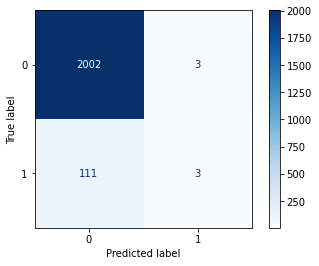

In [162]:
# Check confusion matrix for Model 17
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_train_clustered_sm, y_train_sm)
# Predict
y_pred = best_model.predict(Z_test_clustered)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plot_confusion_matrix(best_model, 
                      Z_test_clustered, y_test, 
                      cmap='Blues', 
                      values_format='d', 
                     )
final_auc = roc_auc_score(y_true = y_test, y_score = best_model.predict_proba(Z_test_clustered)[:,1])

print(f'Accuracy: {(tn+tp)/(tn+tp+fn+fp)} \
\n Sensitivity: {tp/(tp+fn):.3f} \
\n Specificity: {tn/(tn+fp):.3f} \
\n Precision: {tp/(tp+fp):.3f} \
\n Tesst ROC AUC: {final_auc:.3f}')


# # Plot ROC curve
# plot_roc_curve(best_model, Z_test_clustered, y_test)
# # add worst case scenario line
# plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")
# # add title
# plt.title('Receiver Operating Characteristic (ROC) Curve');

It is evident that despite its high ROC_AUC score, Logistic Regression (Model 17) is still strongly preferring to predict negatives in all but 6 cases in the validation set. That is not very helpful to policy makers. True positives are very low (4), and the false negatives are quite high (110). Let's check if XGBoost (Model 18) takes the lazy way out like Logistic.

[13:02:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9226050023596036 
 Sensitivity: 0.254 
 Specificity: 0.961 
 Precision: 0.269 
 Test ROC AUC: 0.832


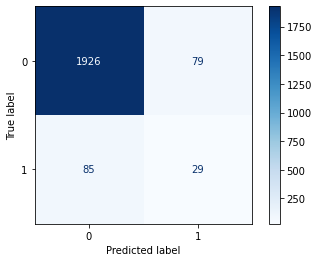

In [163]:
# Check confusion matrix for Model 18
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 13, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_train_clustered_sm, y_train_sm)
# Predict
y_pred = best_model.predict(Z_test_clustered)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plot_confusion_matrix(best_model, 
                      Z_test_clustered, y_test, 
                      cmap='Blues', 
                      values_format='d', 
                     );
final_auc = roc_auc_score(y_true = y_test, y_score = best_model.predict_proba(Z_test_clustered)[:,1])

print(f'Accuracy: {(tn+tp)/(tn+tp+fn+fp)} \
\n Sensitivity: {tp/(tp+fn):.3f} \
\n Specificity: {tn/(tn+fp):.3f} \
\n Precision: {tp/(tp+fp):.3f} \
\n Test ROC AUC: {final_auc:.3f}')


# # Plot ROC curve
# plot_roc_curve(best_model, Z_test_clustered, y_test)
# # add worst case scenario line
# plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")
# # add title
# plt.title('Receiver Operating Characteristic (ROC) Curve');

This is more promising. XGBoost (Model 18) bravely puts 108 predictions as positive, as compared to Model 17 predicting only a measly 6 positive cases. As such, Model 18's sensitivity score is 0.254, which is 877% higher than Model 17's 0.026. 

Considering that:
- Model 18's AUC_ROC score for the test set is marginally lower at 0.832 compared to Model 17's 0.846, 
- Model 18's AUC_ROC Kaggle score is marginally higher at 0.722 compared to Model 17's 0.717, 
- BUT Model 18's sensitivity is much higher at 0.254, versus Model 17's 0.026
we will go with Model 18 as our final selected model.

In [129]:
79+29

108

In [130]:
0.254 / 0.026 - 1

8.76923076923077

## Features of importance

In [131]:
len(best_model.feature_importances_)

198

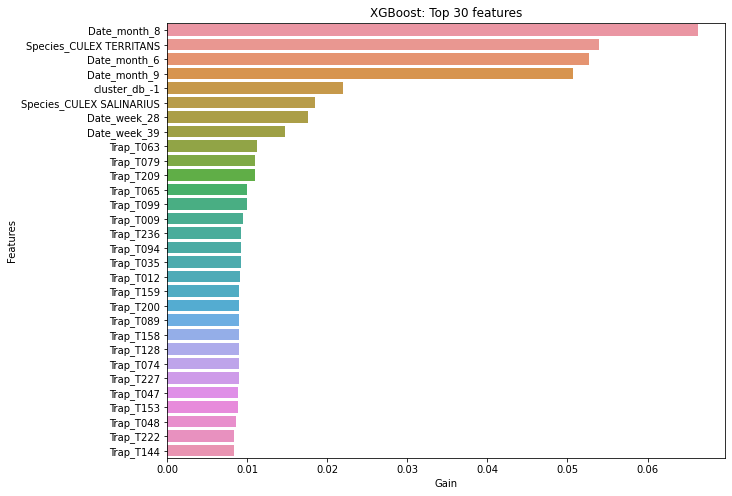

In [132]:
# Obtain coefficients from logit model
feature_values = best_model.feature_importances_

# Obtain feature names from TF-IDF vectorizer
feature_names = Z_clustered.columns

# Create dataframe of features and their coefficients
df_gini = pd.DataFrame(zip(feature_names, feature_values), 
                       columns = ["Features", "Gain"]
                      ).sort_values('Gain', 
                                    ascending = False)

# Plot 20 highest features
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'Gain', y = 'Features', data = df_gini.head(30))
ax.set_title(f"XGBoost: Top 30 features")
ax.set_xlabel("Gain")
ax.set_ylabel("Features");

In XGBoost, the default metric for feature importance is "gain", which is defined as the average gain across all splits the feature is used in, where a gain is the improvement in AUC_ROC score brought by a feature to the branches it is on. 

We make the following observations:
- Month: The month of the year is the most important predictor for WNV cases. August has the highest importance, followed by June, then September. They are responsible for improving AUC_ROC scores by 0.050 to 0.065.
- Species: Mosquito species is the next most important feature, with Culex Territans the highest followed by Culex Salinarius. They are responsible for improving AUC_ROC scores by 0.05 and 0.02 respectively. The other 6 species are absent from the Top 30 chart.
- Cluster: DBSCAN's `Cluster -1` has strong predictive value. This cluster is mainly located in the Northwest and Southwest of the city. It is responsible for improving AUC_ROC score by 0.025.
- Week: The 28th and 39th week of the year are next in line of importance. This falls within the hot summer period of the year.
- Trap: Finally, trap IDs are the next feature of importances. Trap 063, 079 and 209 are most important.
- Weather: Interestingly, we do not see any weather-related features in the Top 30 chart, lagged or unlagged. 

## Reflections

1. While a simpler parametric model like Logistic Regression with high AUC_ROC scores may be more appealing to end-users, the inability to weave complex non-linear interactions may result the model in choosing simple solutions to solving complex problems such as predicting virus locations. As seen in Model 17, it assigns WNV-negative predictions to 99.9% of the test set, when on average 94.6% of the cases are negative. This allows it to achieve a higher AUC_ROC score than all tested models (XGBoost, Random Forest, Extra Trees, Support Vector Machines, KNeighbors). However, its sensitivity is a measly 0.03, which means its usefulness to the government may be limited. This is despite using a 
2. On the other hand, a unsupervised learning model such as XGBoost may be able to deal with an unbalanced data set. This is shown in Model 18, where it 'bravely' predicts 94.9% WNV-negative cases, which is quite true to the 'negative' proportions seen in the original dataset before SMOTE-ing. Its AUC_ROC score is lower than a simple model like Logit, but it has a much higher sensitivity than Logit, which means it may be a more use-able project for city officials in deciding where to spray and tackle the virus problem.
3. We find that tuning hyperparameters using a very extensive grid search does not do much to improve model performance, and sometimes reduces test and Kaggle scores, as seen in Models 7 and 8. We reverted to using a simpler set of parameters in subsequent model testing to achieve better out-of-sample performance.
4. We find that weather features are not too important in predicting the presence of WNV. This is somewhat surprising because we know that dry and hot conditions are more favorable for WNV. Perhaps one explanation is that weather effects are heavily absorbed by the presence of the `month` variable, which is a good proxy for the hot dry summer months.
5. We find that creating our own mosquito clusters is better than using GPS coordinates of longitutde and latitude. This is because the housing and demographic conditions in Chicago does not change evenly from East to West or South to North. Instead, they might appear in blobs or clusters based on historical reasons or terrain features. Because of time limitation, we did not do a grid search over our clustering hyperparameters (eps, min_samples, n_clusters) but this could be an area of improvement for us.